# Fact checking, Neural Languange Inference (**NLI**)

# Intro

This assignment is centred on a particular and emerging NLP task, formally known as **fact checking** (or fake checking). As AI techniques become more and more powerful, reaching amazing results, such as image and text generation, it is more than ever necessary to build tools able to distinguish what is real from what is fake.

Here we focus on a small portion of the whole fact checking problem, which aims to determine whether a given statement (fact) conveys a trustworthy information or not. 

More precisely, given a set of evidences and a fact to verify, we would like our model to correctly predict whether the fact is true or fake.

In particular, we will see:

*   Dataset preparation (analysis and pre-processing)
*   Problem formulation: multi-input binary classification
*   Defining an evaluation method
*   Simple sentence embedding
*   Neural building blocks
*   Neural architecture extension

## Environment setup
The necessary libraries are imported: in particular, we chose PyTorch as deep learning framework.

In [1]:
# System packages
import os
import sys
import glob
import random
from time import time
import re
import gc

# Data and numerical management packages
import pandas as pd
import numpy as np
from scipy.sparse import lil_matrix

# PyTorch's relevant modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Natural language utilities
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.downloader as gloader

# Abstract classes
from abc import ABC, abstractmethod

# Plotting utility
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import Image 

# Metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics.pairwise import cosine_similarity

# Other tools
from urllib import request
import zipfile
from tqdm.notebook import tqdm
from itertools import zip_longest
from collections import OrderedDict, Counter
from scipy.sparse import coo_matrix
import string

# Type hint
from typing import Optional, Callable, Tuple, Dict, List, Union

nltk.download('punkt')
nltk.download('stopwords')

# automatic mixed precision training:
from torch.cuda.amp import autocast 
from torch.cuda.amp import GradScaler

# Use GPU acceleration if possible
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("using this device:", DEVICE)

if not(torch.cuda.is_available()):
  raise Exception("switch to runtime GPU, otherwise the code won't work properly")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
using this device: cuda:0


We fix a global seed in order to ensure reproducibility.

In [2]:
# Set seed for reproducibility
def fix_random(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

Then, we define a token for padding.

In [3]:
# Define padding tag
PAD = '<PAD>'

Finally, we define some utility lambda functions.

In [4]:
# Lambda for computing the mean of a list
mean: Callable[[List[float]], float] = lambda l: sum(l) / len(l)

# Lambda for transforming a list of tuples into a tuple of lists
to_tuple_of_lists: Callable[[List[Tuple]], Tuple[List]] = lambda list_of_tuples: tuple(map(list, zip(*list_of_tuples)))

# Lambda for transforming a tuple of lists into a list of tuples
to_list_of_tuples: Callable[[Tuple[List]], List[Tuple]] = lambda tuple_of_lists: list(zip(*tuple_of_lists))

# Lambda for iterating with batches (if the length of the sequences does not match with the batch size, tuples of empty lists are appended)
batch_iteration: Callable[[List[Tuple]], zip] = lambda data, batch_size: zip_longest(*[iter(data)] * batch_size, fillvalue=([], [], ''))

# The FEVER dataset

First of all, we need to choose a dataset. In this assignment we will rely on the [FEVER dataset](https://fever.ai).

The dataset is about facts taken from Wikipedia documents that have to be verified. In particular, facts could face manual modifications in order to define fake information or to give different formulations of the same concept.

The dataset consists of 185,445 claims manually verified against the introductory sections of Wikipedia pages and classified as ```Supported```, ```Refuted``` or ```NotEnoughInfo```. For the first two classes, systems and annotators need to also return the combination of sentences forming the necessary evidence supporting or refuting the claim.

## Dataset structure

Relevant data is divided into two file types. Information concerning the fact to verify, its verdict and associated supporting/opposing statements are stored in **.jsonl** format. In particular, each JSON element is a python dictionary with the following relevant fields:

*    **ID**: ID associated to the fact to verify.

*    **Verifiable**: whether the fact has been verified or not: ```VERIFIABLE``` or ```NOT VERIFIABLE```.
    
*    **Label**: the final verdict on the fact to verify: ```SUPPORTS```, ```REFUTES``` or ```NOT ENOUGH INFO```.
    
*    **Claim**: the fact to verify.
    
*    **Evidence**: a nested list of document IDs along with the sentence ID that is associated to the fact to verify. In particular, each list element is a tuple of four elements: the first two are internal annotator IDs that can be safely ignored; the third term is the document ID (called URL) and the last one is the sentence number (ID) in the pointed document to consider.

**Some Examples**

---

**Verifiable**

{"id": 202314, "verifiable": "VERIFIABLE", "label": "REFUTES", "claim": "The New Jersey Turnpike has zero shoulders.", "evidence": [[[238335, 240393, "New_Jersey_Turnpike", 15]]]}

---

**Not Verifiable**

{"id": 113501, "verifiable": "NOT VERIFIABLE", "label": "NOT ENOUGH INFO", "claim": "Grease had bad reviews.", "evidence": [[[133128, null, null, null]]]}

---

## Some simplifications and pre-processing

We are only interested in verifiable facts. Thus, we can filter out all non-verifiable claims.

Additionally, the current dataset format does not contain all necessary information for our classification purposes. In particular, we need to download Wikipedia documents and replace reported evidence IDs with the corresponding text.

Don't worry about that! We are providing you the already pre-processed dataset so that you can concentrate on the classification pipeline (pre-processing, model definition, evaluation and training).

You can download the zip file containing all set splits (train, validation and test) of the FEVER dataset by clicking on this [link](https://drive.google.com/file/d/1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1/view?usp=sharing). Alternatively, run the below code cell to automatically download it on this notebook.

**Note**: each dataset split is in .csv format. Feel free to inspect the whole dataset!

In [5]:
import os
import requests
import zipfile

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


## Data analysis
Then, we load the dataset in a `pandas`'s `Dataframe` object.

In [6]:
df_train_toclean = pd.read_csv(os.path.join('dataset', 'train_pairs.csv'), index_col=0)
df_val_toclean = pd.read_csv(os.path.join('dataset', 'val_pairs.csv'), index_col=0)
df_test_toclean = pd.read_csv(os.path.join('dataset', 'test_pairs.csv'), index_col=0)

# Show first rows
print('Training set:')
display(df_train_toclean.head())
print('Validation set:')
display(df_val_toclean.head())
print('Test set:')
display(df_test_toclean.head())

Training set:


,Claim,Evidence,ID,Label
0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS
1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS
2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES
3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS
4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES


Validation set:


,Claim,Evidence,ID,Label
0,The Indian Army comprises part of the country'...,16\tIt is an all-volunteer force and comprises...,98304,SUPPORTS
1,Recovery features Rihanna.,6\tEminem also collaborated with artists such ...,98305,SUPPORTS
2,Rihanna is on Recovery.,6\tEminem also collaborated with artists such ...,98306,SUPPORTS
3,Philomena was nominated.,8\tThe film was nominated in four categories a...,27307,SUPPORTS
4,Vietnam is a mascot.,0\tVietnam -LRB- ˌ ; -LSB- vîət nāːm -RSB- -RR...,98312,REFUTES


Test set:


,Claim,Evidence,ID,Label
0,Anxiety has been linked with physical symptoms.,"13\tFurthermore , anxiety has been linked with...",16387,SUPPORTS
1,Firefox is an application.,0\tMozilla Firefox -LRB- or simply Firefox -RR...,6,SUPPORTS
2,Keegan-Michael Key played President Barack Oba...,"6\tIn 2015 , Key appeared at the White House C...",16392,SUPPORTS
3,Google Search can find stock quotes.,"13\tThese include synonyms , weather forecasts...",16394,SUPPORTS
4,A Good Day to Die Hard was directed solely by ...,1\tThe film was directed by John Moore and wri...,98315,REFUTES


In [7]:
# Some examples of claim-evidence pairs:
for i in range(0, 1000, 100):
    print('\nClaim:', df_train_toclean['Claim'][i])
    print('Evidence:', df_train_toclean['Evidence'][i])
    print('Label:', df_train_toclean['Label'][i])


Claim: Chris Hemsworth appeared in A Perfect Getaway.
Evidence: 2	Hemsworth has also appeared in the science fiction action film Star Trek -LRB- 2009 -RRB- , the thriller adventure A Perfect Getaway -LRB- 2009 -RRB- , the horror comedy The Cabin in the Woods -LRB- 2012 -RRB- , the dark-fantasy action film Snow White and the Huntsman -LRB- 2012 -RRB- , the war film Red Dawn -LRB- 2012 -RRB- , and the biographical sports drama film Rush -LRB- 2013 -RRB- .	Star Trek	Star Trek (film)	A Perfect Getaway	A Perfect Getaway	The Cabin in the Woods	The Cabin in the Woods	Snow White and the Huntsman	Snow White and the Huntsman	Red Dawn	Red Dawn (2012 film)	Rush	Rush (2013 film)
Label: SUPPORTS

Claim: Thirteen Reasons Why was published in 2007.
Evidence: 0	Thirteen Reasons Why is a 2007 young adult novel written by Jay Asher .	Jay Asher	Jay Asher	young adult novel	young adult fiction
Label: SUPPORTS

Claim: The Belko Experiment was directed by Greg Mclean.
Evidence: 0	The Belko Experiment is a 20

In [8]:
# The data is imbalanced: dealt with it by using a weighted loss
print(df_train_toclean['Label'].value_counts())

SUPPORTS    89389
REFUTES     32351
Name: Label, dtype: int64


## Text cleaning

There's still a problem: sometimes between round brackets there are useful information, like a date, or something useless like the word introducing how to write another word in a foreign language. In order to not miss information we must keep also the useless brackets and their content.

In [9]:
########## used in the function "process" to remove words containing non-ASCII characters:
def remove_non_ascii(sentence):
    words = sentence.split()
    cleaned_words = [word for word in words if not containsNonAscii(word)]
    return ' '.join(cleaned_words)

def containsNonAscii(s):
    return any(ord(i) > 127 for i in s)
########

def process(document):
    # Removing the "Evidence ID". It can have a variable number of digits. So:
    document = re.sub('^\d+\s', '', document)

    # Removing phonetic info between square brackets:
    document = re.sub(' -LSB-[^-RSB-]*-RSB- ', '', document)

    # Replace "-LRB-" and "-RRB-" respectively with "(" and ")"
    document = re.sub('-LRB-', '(', document)
    document = re.sub('-RRB-', ')', document)

    # Remove words containing non-ascii characters:
    document = remove_non_ascii(document)

    # Remove everything after the final point:
    document = re.sub(' \.\s.*', ' .', document) 
    document = re.sub(' \!\s.*', ' .', document) 
    document = re.sub(' \?\s.*', ' .', document)

    
    # Remove punctuation marks:
    document = re.sub('[".,\/#!$%\^&\*;:{}=\-_`~()]', '', document)
    
    return document

## apply processing to each evidence document, of each data set:
df_train = df_train_toclean.copy(deep=True)
df_val = df_val_toclean.copy(deep=True)
df_test = df_test_toclean.copy(deep=True)
df_train['Evidence'] = df_train_toclean['Evidence'].apply(process)
df_val['Evidence'] = df_val_toclean['Evidence'].apply(process)
df_test['Evidence'] = df_test_toclean['Evidence'].apply(process)

#### viasualize result:
for i in range(0, 100, 3):
    print('- document before cleaning:')
    print(df_train_toclean['Evidence'][i])
    print('- same document after cleaning:')
    print(df_train['Evidence'][i], '\n')

del df_train_toclean
del df_val_toclean
del df_test_toclean
gc.collect()

- document before cleaning:
2	Hemsworth has also appeared in the science fiction action film Star Trek -LRB- 2009 -RRB- , the thriller adventure A Perfect Getaway -LRB- 2009 -RRB- , the horror comedy The Cabin in the Woods -LRB- 2012 -RRB- , the dark-fantasy action film Snow White and the Huntsman -LRB- 2012 -RRB- , the war film Red Dawn -LRB- 2012 -RRB- , and the biographical sports drama film Rush -LRB- 2013 -RRB- .	Star Trek	Star Trek (film)	A Perfect Getaway	A Perfect Getaway	The Cabin in the Woods	The Cabin in the Woods	Snow White and the Huntsman	Snow White and the Huntsman	Red Dawn	Red Dawn (2012 film)	Rush	Rush (2013 film)
- same document after cleaning:
Hemsworth has also appeared in the science fiction action film Star Trek  2009   the thriller adventure A Perfect Getaway  2009   the horror comedy The Cabin in the Woods  2012   the darkfantasy action film Snow White and the Huntsman  2012   the war film Red Dawn  2012   and the biographical sports drama film Rush  2013   

- 

15

# Classification dataset

At this point, you should have a ready-to-go dataset! Note that the dataset format changed as well! In particular, we split the evidence set associated to each claim, in order to build (claim, evidence) pairs. The classification label is propagated as well.

We'll motivate this decision in the next section!

Just for clarity, here's an example of the pre-processed dataset:

---

**Claim**: "Wentworth Miller is yet to make his screenwriting debut."

**Evidence**: "2	He made his screenwriting debut with the 2013 thriller film Stoker .	Stoker	Stoker (film)"

**Label**: Refutes

---

**Note**: The dataset requires some text cleaning as you may notice!


# Problem formulation

As mentioned at the beginning of the assignment, we are going to formulate the fact checking problem as a binary classification task.

In particular, each dataset sample is comprised of:

*     A claim to verify
*     A set of semantically related statements (evidence set)
*     Fact checking label: either evidences _support_ or _refute_ the claim.

Handling the evidence set from the point of view of neural models may imply some additional complexity: if the evidence set is comprised of several sentences we might incur in memory problems.

To this end, we further simplify the problem by building (claim, evidence) pairs. The fact checking label is propagated as well.

Example:

     Claim: c1 
     Evidence set: [e1, e2, e3]
     Label: S (support)

--->

    (c1, e1, S),
    (c1, e2, S),
    (c1, e3, S)

## Schema

The overall binary classification problem is summed up by the following (simplified) schema

![](https://drive.google.com/uc?export=view&id=1Wm_YBnFwgJtxcWEBpPbTBEVkpKaL08Jp)

Don't worry too much about the **Encoding** block for now. We'll give you some simple guidelines about its definition. For the moment, stick to the binary classification task definition where, in this case, we have 2 inputs: the claim to verify and one of its associated evidences.

# Architecture Guidelines

There are many neural architectures that follow the above schema. To avoid phenomena like the writer's block, in this section we are going to give you some implementation guidelines.

In particular, we would like you to test some implementations so that you explore basic approaches (neural baselines) and use them as building blocks for possible extensions.

## Handling multiple inputs

The first thing to notice is that we are in a multi-input scenario. In particular, each sample is comprised of a fact and its associated evidence statement.

Each of these input is encoded as a sequence of tokens. In particular, we will have the following input matrices:

*    Claim: [batch_size, max_tokens]
*    Evidence: [batch_size, max_tokens]

Moreover, after the embedding layer, we'll have:

*    Claim: [batch_size, max_tokens, embedding_dim]
*    Evidence: [batch_size, max_tokens, embedding_dim]

But, we would like to have a 2D input to our classifier, since we have to give an answer at pair level. Therefore, for each sample, we would expect the following input shape to our classification block:

*   Classification input shape: [batch_size, dim]

**How to do that?**

We inherently need to reduce the token sequence to a single representation. This operation is formally known as **sentence embedding**. Indeed, we are trying to compress the information of a whole sequence into a single embedding vector.

Here are some simple solutions that we ask you to try out:

*   Encode token sequences via a RNN and take the last state as the sentence embedding. 

*   Encode token sequences via a RNN and average all the output states.

*   Encode token sequences via a simple MLP layer. In particular, if your input is a [batch_size, max_tokens, embedding_dim] tensor, the matrix multiplication works on the **max_tokens** dimension, resulting in a [batch_size, embedding_dim] 2D matrix. 

*   Compute the sentence embedding as the mean of its token embeddings (**bag of vectors**).

## Merging multi-inputs

At this point, we have to think about **how** we should merge evidence and claim sentence embeddings.

For simplicity, we stick to simple merging strategies:

*     **Concatenation**: define the classification input as the concatenation of evidence and claim sentence embeddings

*     **Sum**: define the classification input as the sum of evidence and claim sentence embeddings

*     **Mean**: define the classification input as the mean of evidence and claim sentence embeddings

For clarity, if we the sentence embedding of a single input has shape [batch_size, embedding_dim], then the classification input has shape:

*     **Concatenation**: [batch_size, 2 * embedding_dim]

*     **Sum**: [batch_size, embedding_dim]

*     **Mean**: [batch_size, embedding_dim]

## A simple extension

Lastly, we ask you to modify previously defined neural architectures by adding an additional feature to the classification input.

We would like to see if some similarity information between the claim to verify and one of its associated evidence might be useful to the classification.

Compute the cosine similarity metric between the two sentence embeddings and concatenate the result to the classification input.

For clarity, since the cosine similarity of two vectors outputs a scalar value, the classification input shape is modified as follows:

*     **Concatenation**: [batch_size, 2 * embedding_dim + 1]

*     **Sum**: [batch_size, embedding_dim + 1]

*     **Mean**: [batch_size, embedding_dim + 1]



# Word embeddings
GloVe embedding is employed to represent the words in the corpus as vectors. In particular, 300 dimensions are chosen, since it's a good trade off between performance and memory footprint.

In [10]:
print('Downloading GloVe model...')
emb_dim = 300
glove_model = gloader.load('glove-wiki-gigaword-'+str(emb_dim))
print('\nDownload completed.')

[==================================================] 100.0% 376.1/376.1MB downloaded

Download completed.


Word mappings and co-occurrence matrices (with window size = 3) are preventively produced in order to better handle OOV words in the following sections:
- one vocabulary contains only the words from the training set, and it will be used to train the model;
- one vocabulary contains the words from training and validation set, and it will be used to validate the model;
- one vocabulary contains the words from the whole dataset (train + val + test), and it will be used to evaluate the final model.

In [11]:
def build_vocabulary(corpus: List[List[str]],
                     old_word_listing: Optional[List[str]] = None) -> (Dict[int, str], Dict[int, str], List[str]):
    
    flat_tokens = [x for sub in corpus for x in sub]
    
    if old_word_listing is None:  # standard case
        word_listing = [PAD] + list(OrderedDict.fromkeys(flat_tokens))
    else:  # case in which we extend an already existing vocabulary
        word_listing = list(OrderedDict.fromkeys(old_word_listing + flat_tokens))
        
    idx_to_word = {i: w for i, w in enumerate(word_listing)}
    word_to_idx = {w: i for i, w in enumerate(word_listing)}

    return idx_to_word, word_to_idx, word_listing

def build_co_occurrence_matrix(corpus: List[str],
                               word_to_idx: Dict[str, int],
                               window_size: Optional[int] = 3) -> np.ndarray:
    
    # Initialize sparse matrix
    co_occurrence_matrix = lil_matrix((len(word_to_idx), len(word_to_idx)))

    for doc in tqdm(corpus, leave=False):
        for cur_idx in range(len(doc)):
            # Sliding window to extract context words
            win_start = max(0, cur_idx - window_size)
            win_stop = min(len(doc), cur_idx + window_size + 1)
            context_words = doc[win_start:win_stop]
            # Extract central word
            central_word = context_words.pop(min(cur_idx, window_size))
            # Compute co-occurrence matrix for given central word
            for context_word in context_words:
                key_central = word_to_idx[central_word]
                key_context = word_to_idx[context_word]
                co_occurrence_matrix[key_central, key_context] += 1
    
    return co_occurrence_matrix

# Tokenize corpus
X_trainC = df_train['Claim'].apply(lambda x: nltk.word_tokenize(x))
X_trainE = df_train['Evidence'].apply(lambda x: nltk.word_tokenize(x))
Y_train = df_train['Label'].tolist()

train_corpus = X_trainC + X_trainE

X_valC = df_val['Claim'].apply(lambda x: nltk.word_tokenize(x))
X_valE = df_val['Evidence'].apply(lambda x: nltk.word_tokenize(x))
Y_val = df_val['Label'].tolist()

val_corpus = X_valC + X_valE

X_testC = df_test['Claim'].apply(lambda x: nltk.word_tokenize(x))
X_testE = df_test['Evidence'].apply(lambda x: nltk.word_tokenize(x))
Y_test = df_test['Label'].tolist()

test_corpus = X_testC + X_testE

# Get word mappings for each set
train_idx_to_word, train_word_to_idx, train_word_listing = build_vocabulary(train_corpus)
val_idx_to_word, val_word_to_idx, val_word_listing = build_vocabulary(val_corpus, old_word_listing=train_word_listing)
test_idx_to_word, test_word_to_idx, test_word_listing = build_vocabulary(test_corpus, old_word_listing=val_word_listing)

# Mapping of labels
label_to_idx = {'REFUTES': 0, 'SUPPORTS': 1}
idx_to_label = {0: 'REFUTES', 1: 'SUPPORTS'}

# Build co-occurrence matrix with window size = 1 for each set
train_co_occurrence_matrix = build_co_occurrence_matrix(train_corpus, train_word_to_idx)
print('Shape of co-occurrence matrix (training set):', train_co_occurrence_matrix.shape)
val_co_occurrence_matrix = build_co_occurrence_matrix(val_corpus, val_word_to_idx)
print('Shape of co-occurrence matrix (validation set):', val_co_occurrence_matrix.shape)
test_co_occurrence_matrix = build_co_occurrence_matrix(test_corpus, test_word_to_idx)
print('Shape of co-occurrence matrix (test set):', test_co_occurrence_matrix.shape)

Shape of co-occurrence matrix (training set): (38780, 38780)


Shape of co-occurrence matrix (validation set): (40685, 40685)


Shape of co-occurrence matrix (test set): (42892, 42892)


OOV words are then checked.

In [12]:
train_oov_words = [word for word in train_word_listing if word not in glove_model.vocab and word != PAD]
val_oov_words = [word for word in val_word_listing if word not in glove_model.vocab and word != PAD]
test_oov_words = [word for word in test_word_listing if word not in glove_model.vocab and word != PAD]

print(f'Total OOV terms in training set: {len(train_oov_words)} ({float(len(train_oov_words)) / len(train_word_listing) * 100:.2f}%)')
print(f'Total OOV terms in validation set: {len(val_oov_words)} ({float(len(val_oov_words)) / len(val_word_listing) * 100:.2f}%)')
print(f'Total OOV terms in test set: {len(test_oov_words)} ({float(len(test_oov_words)) / len(test_word_listing) * 100:.2f}%)')

Total OOV terms in training set: 22709 (58.56%)
Total OOV terms in validation set: 23998 (58.98%)
Total OOV terms in test set: 25432 (59.29%)


Thus, an embedding matrix in which such words are handled with the **neighbours** strategy is built; in particular, OOV words are handled in cascade:
- first we compute an embedding for OOV words from training set (OOV1);
- then we do the same thing for the validation set (OOV2) w.r.t. the original vocabulary + OOV1;
- finally, we compute the embedding of OOV words from test set w.r.t. the original vocabulary + OOV1 + OOV2.

In fact, if we had used three separate embeddings we could have obtained different embeddings for the same OOV word, if such word appeared in all the three subsets.

In [13]:
stop_words = stopwords.words('english')
punctuation_marks = string.punctuation + "``" + "''" + "..."

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.Word2VecKeyedVectors,
                           word_to_idx: Dict[str, int],
                           idx_to_word: Dict[int, str],
                           oov_words: List[str],
                           co_occurrence_matrix: np.ndarray,
                           old_embedding_matrix: Optional[np.ndarray] = None):
    # Initialize embedding matrix with all zeros
    embedding_matrix = np.zeros((len(word_to_idx), embedding_model.vector_size))
    
    # Helper function to analyze embeddings
    def analyze_embedding() -> (float, float):
        mean_list, std_list = [], []
        for word in word_to_idx.keys():
            if word not in oov_words and word != PAD:
                embed = embedding_model[word]
                # Compute mean and std
                mean_list.append(np.mean(embed))
                std_list.append(np.std(embed))

        embedding_mean = mean(mean_list)
        embedding_std = mean(std_list)

        return embedding_mean, embedding_std
    
    # Get mean and std for the embeddings
    embedding_mean, embedding_std = analyze_embedding()
    
    # Helper function to find the embedding of an OOV word
    def get_oov_embedding(oov):
        oov_idx = word_to_idx[oov]
        if old_embedding_matrix is None or oov_idx >= len(old_embedding_matrix):
            # Strategy based on co-occurrence
            # Retrieve indexes of word's neighbours (i.e. the indexes of nonzero elements)
            neighbors_idx = co_occurrence_matrix[oov_idx].nonzero()[-1]  # take the last element (for lil_matrix case)
            # Filter non-oov neighbours
            non_oov_neighbors = [idx_to_word[idx] for idx in neighbors_idx if idx_to_word[idx] not in oov_words]

            if len(non_oov_neighbors) > 0:  # neighbours are not OOV

                ############ weighted mean wrt the occurences of each neihbour: 
                co_occ_oov = coo_matrix(co_occurrence_matrix[oov_idx]) # co_occurence vector of the oov word converted in coo_matrix to use later the method ".data"
                tot_weights = 0
                oov_embedding = np.zeros(embedding_model.vector_size) 
                for idx,w in enumerate(non_oov_neighbors):
                  occurrence = co_occ_oov.data[idx]  # number of occurences of the neighbour 
                  if w not in punctuation_marks and w not in stop_words:  # to avoid considering non-informative words
                      oov_embedding += embedding_model[w]*occurrence
                      tot_weights += occurrence

                if tot_weights == 0:
                  oov_embedding = np.random.normal(loc=embedding_mean, scale=embedding_std, size=embedding_model.vector_size)
                else:
                  oov_embedding = oov_embedding/tot_weights
                ############

            else:  # neighbours are OOV
                oov_embedding = np.random.normal(loc=embedding_mean, scale=embedding_std, size=embedding_model.vector_size)
                
        else:
            oov_embedding = old_embedding_matrix[oov_idx]
            
        return oov_embedding

    for word, idx in tqdm(word_to_idx.items(), leave=False):
        # If word is PAD no action is performed (it will be assigned the zero vector)
        if word not in oov_words and word != PAD:
            embedding_matrix[idx] = embedding_model[word]
        elif word in oov_words:
            embedding_matrix[idx] = get_oov_embedding(word)
            
    return embedding_matrix

# Build embedding matrix based only on the training set (for training)
train_embedding_matrix = build_embedding_matrix(glove_model, train_word_to_idx, train_idx_to_word, train_oov_words, train_co_occurrence_matrix)
print('Shape of embedding matrix (training set):', train_embedding_matrix.shape)

# Build embedding matrix based on training + validation set (for validation)
val_embedding_matrix = build_embedding_matrix(glove_model, val_word_to_idx, val_idx_to_word, val_oov_words, val_co_occurrence_matrix, train_embedding_matrix)
print('Shape of embedding matrix (validation set):', val_embedding_matrix.shape)

# Build embedding matrix based on training + validation + test set (for test)
test_embedding_matrix = build_embedding_matrix(glove_model, test_word_to_idx, test_idx_to_word, test_oov_words, test_co_occurrence_matrix, val_embedding_matrix)
print('Shape of embedding matrix (test set):', test_embedding_matrix.shape)

# Delete co-occurrence matrices to free space in RAM
del train_co_occurrence_matrix
del val_co_occurrence_matrix
del test_co_occurrence_matrix
gc.collect();

Shape of embedding matrix (training set): (38780, 300)


Shape of embedding matrix (validation set): (40685, 300)


Shape of embedding matrix (test set): (42892, 300)


Finally, a utility class is defined: it encapsulates the embedding matrix and, given a batch of sequences, returns a tensor containing the corresponding (padded) embeddings.

In [ ]:
class Embedder:
    def __init__(self,
                 embedding_matrix: np.ndarray,
                 word_to_idx: Dict[str, int]):
        self.embedding_matrix = embedding_matrix
        self.word_to_idx = word_to_idx
    
    def get_word_embedding(self,
                           batch_word_seq: Tuple[List[str]],
                           max_len: Optional[int] = None) -> (torch.FloatTensor, torch.IntTensor):
        if max_len is None:
          # Find maximum length of batch
          max_len = max(map(len, batch_word_seq))

        batch_embedding = []
        lengths = []
        for word_seq in batch_word_seq:
            if word_seq:  # Handle partial batches
                orig_len = len(word_seq)
                pad_len = max_len - orig_len
                # Keep track of original length
                lengths.append(orig_len)

                # Pad sequence
                padded_seq = word_seq + [PAD] * pad_len
                # Embed padded sequence
                embedded_seq = [self.embedding_matrix[self.word_to_idx[w]] for w in padded_seq]
                batch_embedding.append(embedded_seq)
        
        return torch.cuda.FloatTensor(batch_embedding, device = DEVICE), torch.cuda.IntTensor(lengths, device = DEVICE)

# Create embedding helpers
train_embedder = Embedder(train_embedding_matrix, train_word_to_idx)
val_embedder = Embedder(val_embedding_matrix, val_word_to_idx)
test_embedder = Embedder(test_embedding_matrix, test_word_to_idx)

# Encoders
Here we define the 4 encoders:
- a RNN in which the last state is the embedding (`RNNLastState`);
- a RNN in which the average of the output states is the embedding (`RNNAverage`);
- a MLP;
- a model computing the mean of each token embedding to produce an sentence embedding (bag of vectors).

For clarity, we also define an abstract class `SentenceEncoder`, from which our models will inherit.

In [ ]:
class SentenceEncoder(ABC, nn.Module):
    @abstractmethod
    def get_output_dim(self):
        pass
    @abstractmethod
    def forward(self, x: torch.Tensor, x_lengths: Optional[torch.IntTensor] = None) -> torch.Tensor:
        pass

## 1. RNNLastState
The embedding of the sequence is the last state.

In [ ]:
class RNNLastState(SentenceEncoder):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 bidirectional: Optional[bool] = True,
                 num_layers: Optional[int] = 1):
        super(RNNLastState, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            bidirectional=bidirectional,
                            batch_first=True,
                            num_layers = num_layers)

        self.bidirectional = bidirectional
        self.num_directions = 2 if self.bidirectional else 1
        self.num_layers = num_layers
    
    def get_output_dim(self):
        return self.lstm.hidden_size * self.num_directions * self.num_layers

    def _get_lstm_features(self, x: torch.Tensor, x_lengths: torch.IntTensor) -> torch.Tensor:
        # Ignore padding in LSTM
        x = nn.utils.rnn.pack_padded_sequence(x, x_lengths.cpu(), batch_first=True, enforce_sorted=False)  # lengths.cpu() needed because of pytorch bug
        # Feed into LSTM
        x, (last_hidden, _) = self.lstm(x)
        # Undo packaging
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        # Return last hidden state
        return x, last_hidden
    
    def forward(self, x: torch.Tensor, x_lengths: Optional[torch.IntTensor] = None) -> torch.Tensor:
        batch_size, seq_len, _ = x.size()
        
        # Feed into LSTM
        x, last_hidden = self._get_lstm_features(x, x_lengths)

        # Return only the last hidden state
        return torch.cat([last_hidden[0, :, :], last_hidden[1, :, :]], dim=1)

## 2. RNNAverage
The embedding of the sequence is the average of the hidden states.

In [ ]:
class RNNAverage(SentenceEncoder):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 bidirectional: Optional[bool] = True,
                 num_layers: Optional[int] = 1):
        super(RNNAverage, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            bidirectional=bidirectional,
                            batch_first=True,
                            num_layers = num_layers)
        
        self.bidirectional = bidirectional
        self.num_directions = 2 if self.bidirectional else 1
        self.num_layers = num_layers
 
    def get_output_dim(self):
        return self.lstm.hidden_size * self.num_directions

    def _get_lstm_features(self, x: torch.Tensor, x_lengths: torch.IntTensor) -> torch.Tensor:
        # Ignore padding in LSTM
        x = nn.utils.rnn.pack_padded_sequence(x, x_lengths.cpu(), batch_first=True, enforce_sorted=False) # lengths.cpu() needed because of pytorch bug
        # Feed into LSTM
        x, _ = self.lstm(x)
        # Undo packaging
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)

        return x
    
    def forward(self, x: torch.Tensor, x_lengths: Optional[torch.IntTensor] = None) -> torch.Tensor:
        batch_size, seq_len, _ = x.size()
        # Re-initialize hidden layer before each batch, otherwise the LSTM will treat
        # a new batch as a continuation of a sequence
        
        # Feed into LSTM
        x = self._get_lstm_features(x, x_lengths)
        
        # Return the mean along second dim (taking into account padding)
        return torch.sum(x, dim=1) / x_lengths.unsqueeze(dim=1)

## 3. MLP
The embedding of the sentence is computed using a MLP.

In [ ]:
class MLP(SentenceEncoder):
    def __init__(self, dimensions: List[int]):
        super(MLP, self).__init__()

        assert len(dimensions) >= 2, 'You need to specify at least an input and output dimension.'

        self.fc = nn.ModuleList()

        for i in range(len(dimensions)-1):
            layer = nn.Linear(in_features=dimensions[i], out_features=dimensions[i+1])
            self.fc.append(layer)

        self.relu = nn.ReLU()
    
    def get_output_dim(self):
        return self.fc[-1].out_features

    def forward(self, x: torch.Tensor, x_lengths: Optional[torch.IntTensor] = None) -> torch.Tensor:

        # x shape: (batch, max_token, embedding)
        x = x.flatten(start_dim=1)
        # x shape: (batch, max_token*embedding)

        for i in range(len(self.fc)):

            x = self.fc[i](x)
            x = self.relu(x)

        return x

## 4. MeanEmbedder
In the last model, the embedding of the sentence is not learnt, as it is simply computed as the mean of the embeddings of its tokens.

In [ ]:
class MeanEmbedder(SentenceEncoder):
    def __init__(self, emb_dim: int):
        super(MeanEmbedder, self).__init__()
        self.emb_dim = emb_dim
    
    def get_output_dim(self):
        return self.emb_dim

    def forward(self, x: torch.Tensor, x_lengths: Optional[torch.IntTensor] = None) -> torch.Tensor:
        # Return the mean along second dim (taking into account padding)
        return torch.sum(x, dim=1) / x_lengths.unsqueeze(dim=1)

# Final model
The final model is composed of two sub-models:
- a `SentenceEncoder`, which takes in input one sentence and outputs its embedding;
- a classifier, which given the merged embedding of claim and evidence, outputs a label.

The `forward` method takes in input two tensors: one containing the embeddings of the claim, and one containing the embeddings of the evidence. They are fed into the encoder, which outputs the sentence embedding of the claim and of the evidence; these are merged together according to the given strategy, and optionally concatenated with an additional feature, the cosine similarity between them. Finally, the merged sentence embedding is processed by the classifier.

In [ ]:
class ClaimProver(nn.Module):
    def __init__(self,
                 encoder: SentenceEncoder,
                 classifier: nn.Module,
                 merge_strategy: Optional[str] = 'concat',
                 use_cos_sim: Optional[bool] = False):
        super(ClaimProver, self).__init__()

        self.encoder = encoder
        self.classifier = classifier
        self.merge_strategy = merge_strategy
        self.use_cos_sim = use_cos_sim
    
    def forward(self,
                x1: torch.Tensor,
                x2: torch.Tensor,
                x1_lengths: Optional[torch.IntTensor] = None,
                x2_lengths: Optional[torch.IntTensor] = None):
        # Encode both inputs
        
        
        x1 = self.encoder(x1, x1_lengths)
        x2 = self.encoder(x2, x2_lengths)
        # Merge according to strategy
        if self.merge_strategy == 'sum':
            encoding = x1 + x2  # SUM
        elif self.merge_strategy == 'avg':
            encoding = (x1 + x2) / 2  # AVERAGE
        elif self.merge_strategy == 'concat':
            encoding = torch.cat((x1, x2), dim=1)  # CONCATENATION
        # Optionally add cosine similarity feature
        if self.use_cos_sim:
            # Compute cosine similarity between corresponding embeddings inside the batch:
            # the slices are reshaped to (1, batch) to match cosine_similarity API specifications for "single sample" case
            cos_sim = [cosine_similarity(slice_x1.view(1, -1),
                                         slice_x2.view(1, -1)) for slice_x1, slice_x2 in zip(x1.detach().cpu(), x2.detach().cpu())]
            # Convert the list into torch tensor
            cos_sim = torch.from_numpy(np.concatenate(cos_sim, axis=0)).to(DEVICE)
            # Concatenate cosine similarity to original tensor:
            # encoding has shape (batch, emb_size), cos_sim has shape (batch, 1)
            # torch.cat requires shapes (emb_size, batch) and (1, batch), so both are transposed
            encoding = torch.cat((encoding.transpose(0, 1), cos_sim.transpose(0, 1)), dim=0).transpose(0, 1)  # transpose to restore original shape (batch, emb_size + 1)
        
        out = self.classifier(encoding)
        
        return out

# Training

## All models + standard merging
In this section, each model is trained using standard "concat" merging strategy. In particular, the training proceeds as follows:
- binary cross entropy loss function (with integrated sigmoid);
- Adam optimizer with learning rate set to $10^{-3}$;
- early stopping on validation loss with patience = $5$ and tolerance = $10^{-4}$;
- mini-batch of size $64$;
- sentence embedding of size $64$ (except for `MeanEmbedder` with is forced to use the same dimension as the input's).

#### Please notice that the _loss is weighted_ in order to contrast class imbalance.

In [ ]:
# Prepare data
train_data = to_list_of_tuples((X_trainC, X_trainE, Y_train))
val_data = to_list_of_tuples((X_valC, X_valE, Y_val))
test_data = to_list_of_tuples((X_testC, X_testE, Y_test))

# Get class counts and compute weight
(supports, refutes) = df_train['Label'].value_counts()
weight_positive_class = torch.cuda.FloatTensor([refutes/supports], device=DEVICE)

# Define criterion
criterion = nn.BCEWithLogitsLoss(pos_weight=weight_positive_class)  # it applies the sigmoid internally.

# Epochs and batch size
EP = 25
BS = 64
merge_strategy = 'concat'

Utility functions for training and evaluation are defined.

In [ ]:
def train(model: ClaimProver,
          data: List[Tuple[List[str], List[str], str]],
          batch_size: int,
          criterion: Callable[[torch.Tensor, torch.Tensor], float],
          optimizer: torch.optim,
          embedder: Embedder,
          label_to_idx: Dict[str, int],
          max_len: Optional[int] = None,
          verbose: Optional[bool] = False,
          scaler: Optional[torch.cuda.amp.grad_scaler.GradScaler] = False) -> (float, float, float):
    loss_data = []
    correct = 0
    total = 0
    
    # Create batch iterator
    batch_iter = batch_iteration(data, batch_size)
    steps = len(data) // batch_size if len(data) % batch_size == 0 else len(data) // batch_size + 1
    if verbose:
        batch_iter = tqdm(batch_iter, total=steps, leave=False)
    for batch in batch_iter:
        
        # Extract samples
        (claims, evidences, labels) = to_tuple_of_lists(batch)
        
        # Get encoding of claims, evidences and labels, and move them to GPU if available
        claims_tensor, claims_lengths = embedder.get_word_embedding(claims, max_len)
        evidences_tensor, evidences_lengths = embedder.get_word_embedding(evidences, max_len)
        labels_tensor = torch.cuda.FloatTensor([label_to_idx[l] for l in labels if len(l) > 0], device = DEVICE)
        
        if scaler:
           
            # Make prediction
            optimizer.zero_grad()
            with autocast():   #https://pytorch.org/docs/stable/notes/amp_examples.html
                scores = model(claims_tensor, evidences_tensor, claims_lengths, evidences_lengths)
                loss = criterion(scores, labels_tensor.unsqueeze(dim=1))
            # Backpropagation
        
            scaler.scale(loss).backward()  #https://pytorch.org/docs/stable/notes/amp_examples.html
            scaler.step(optimizer) #https://pytorch.org/docs/stable/notes/amp_examples.html
            scaler.update() #https://pytorch.org/docs/stable/notes/amp_examples.html
            
        else:
            # Make prediction
            optimizer.zero_grad()
            scores = model(claims_tensor, evidences_tensor, claims_lengths, evidences_lengths)
            loss = criterion(scores, labels_tensor.unsqueeze(dim=1))
            
            # Backpropagation
            loss.backward()  
            optimizer.step() 

        # Compute accuracy
        scores = torch.sigmoid(scores)
        total_batch = scores.shape[0]
        predictions = scores.squeeze() > 0.5
        correct_batch = (predictions == labels_tensor).sum().item()

        # Update history
        loss_data.append(loss.item())
        correct += correct_batch
        total += total_batch
        

        
    return mean(loss_data), correct / total * 100

def evaluate(model: nn.Module,
             data: List[Tuple[List[str], List[str], str]],
             batch_size: int,
             criterion: Callable[[torch.Tensor, torch.Tensor], float],
             embedder: Embedder,
             label_to_idx: Dict[str, int],
             max_len: Optional[int] = None,
             verbose: Optional[bool] = False) -> (float, float, float):
    loss_data = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        # Create batch iterator
        batch_iter = batch_iteration(data, batch_size)
        steps = len(data) // batch_size if len(data) % batch_size == 0 else len(data) // batch_size + 1
        if verbose:
            batch_iter = tqdm(batch_iter, total=steps, leave=False)
        for batch in batch_iter:
            # Extract samples
            (claims, evidences, labels) = to_tuple_of_lists(batch)
            
            # Get encoding of claims, evidences and labels, and move them to GPU if available
            claims_tensor, claims_lengths = embedder.get_word_embedding(claims, max_len)
            evidences_tensor, evidences_lengths = embedder.get_word_embedding(evidences, max_len)
            labels_tensor = torch.cuda.FloatTensor([label_to_idx[l] for l in labels if len(l) > 0], device = DEVICE)
            
            # Make prediction
            scores = model(claims_tensor, evidences_tensor, claims_lengths, evidences_lengths)

            # Compute loss
            loss = criterion(scores, labels_tensor.unsqueeze(dim=1))
            
            # Compute accuracy
            total_batch = scores.shape[0]
            scores = torch.sigmoid(scores)
            predictions = scores.squeeze() > 0.5
            correct_batch = (predictions == labels_tensor).sum().item()
        
            # Update history
            loss_data.append(loss.item())
            correct += correct_batch
            total += total_batch
              
    return mean(loss_data), correct / total * 100
    

def training_loop(model: nn.Module,
                  train_data: List[Tuple[List[str], List[str]]],
                  optimizer: torch.optim,
                  epochs: int,
                  batch_size: int,
                  criterion: Callable[[torch.Tensor, torch.Tensor], float],
                  train_embedder: Embedder,
                  label_to_idx: Dict[str, int],
                  val_embedder: Optional[Embedder] = None,
                  max_len: Optional[int] = None,
                  lr_scheduler: torch.optim.lr_scheduler = None,
                  val_data: Optional[List[Tuple[List[str], List[str]]]] = None,
                  early_stopping: Optional[bool] = False,
                  patience: Optional[int] = 5,
                  tolerance: Optional[float] = 1e-4,
                  checkpoint_path: Optional[str] = None,
                  verbose: Optional[bool] = True,
                  seed: Optional[int] = 42,
                  mix_scale: Optional[bool] = True) -> (Dict[str, List[float]]):
    # Set seed for reproducibility
    if seed:
        random.seed(seed)

    history = {'loss': [],
               'accuracy': [],
               'val_loss': [],
               'val_accuracy': []}
    
    # Initialize variables for early stopping (if required)
    if val_data and val_embedder and early_stopping:
        min_val_loss = np.inf
        no_improve_counter = 0
    
    scaler = GradScaler() if mix_scale else False   # https://pytorch.org/docs/stable/notes/amp_examples.html
    
    for ep in range(epochs):
        if verbose:
            print('-' * 100)
            print(f'Epoch {ep + 1}/{epochs}')
        
        # Shuffle training set at each epoch
        random.shuffle(train_data)
        
        start = time()
        train_loss, train_accuracy = train(model, train_data, batch_size, criterion, optimizer, train_embedder,label_to_idx, max_len, verbose, scaler)
        end = time()
        
        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)
        if verbose:
            print(f'\tLoss: {train_loss:.5f} - Accuracy: {train_accuracy:.2f}% [Time elapsed: {end - start:.2f} s]')
        
        # Do validation if required
        if val_data and val_embedder:
            
            # Shuffle validation set at each epoch
            random.shuffle(val_data)
            
            start = time()
            val_loss, val_accuracy = evaluate(model, val_data, batch_size, criterion, val_embedder, label_to_idx, max_len, verbose)
            end = time()
            
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)
            if verbose:
                print(f'\tValidation loss: {val_loss:.5f} - Validation accuracy: {val_accuracy:.2f}% [Time elapsed: {end - start:.2f} s]')
            
            if early_stopping and checkpoint_path:
                # If validation loss is lower than minimum, update minimum
                if val_loss < min_val_loss - tolerance:
                    min_val_loss = val_loss
                    no_improve_counter = 0
                    
                    # Save model
                    torch.save(model.state_dict(), checkpoint_path)
                # otherwise increment counter
                else:
                    no_improve_counter += 1
                # If loss did not improve for 'patience' epochs, break
                if no_improve_counter == patience:
                    if verbose:
                        print(f'Early stopping: no improvement in validation loss for {patience} epochs from {min_val_loss:.5f}')
                    # Restore model to best
                    model.load_state_dict(torch.load(checkpoint_path))
                    model.eval()
                    break
        
        # If lr scheduling is used, invoke next step
        if lr_scheduler:
            lr_scheduler.step()
    
    return history

In [ ]:
def plot_history(history, title, save = True):    
    # this function is simply used to plot and save the image (and the dictionary) about the train and val loss and accuracy during the training
    fig = plt.figure()
    fig.figsize=(40, 40)
    plt.suptitle(title, size='xx-large')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(history['loss'], label='train_loss')
    ax1.plot(history['val_loss'], label='val_loss')
    ax1.set_title('BCE loss')
    ax1.set(xlabel='# Epochs')
    ax1.grid()
    ax1.legend();

    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(history['accuracy'], label='train_accuracy')
    ax2.plot(history['val_accuracy'], label='val_accuracy')
    ax2.set_title('Accuracy')
    ax2.set(xlabel='# Epochs')
    ax2.grid()
    ax2.legend();
    plt.show()

    if save:
        fig_title = "_".join( title.split() )
        fig.savefig("figure_"+fig_title+'.png')
        
        # save dictionary:  
        f = open("dict_"+ fig_title +".txt","w")
        f.write(str(history))
        f.close()

### 1. RNNLastState + 'concat'
Here we train the `RNNLastState` model with default 'concat' strategy.

In [ ]:
# clear gpu memory before another training:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Build model
encoder = RNNLastState(input_size=emb_dim , hidden_size=32, bidirectional = True, num_layers =1).to(DEVICE)  # 32 * 2 = 64 due to bidirectionality
classifier_in_features = encoder.get_output_dim() * 2 if merge_strategy == 'concat' else encoder.get_output_dim()
classifier = nn.Linear(in_features=classifier_in_features, out_features=1)
prover = ClaimProver(encoder, classifier).to(DEVICE)

In [ ]:
# Define Adam optimizer
optimizer = torch.optim.Adam(prover.parameters(), lr=1e-3)

history = training_loop(model=prover,
                        train_data=train_data,
                        optimizer=optimizer,
                        epochs=EP,
                        batch_size=BS,
                        criterion=criterion,
                        train_embedder=train_embedder,
                        label_to_idx=label_to_idx,
                        val_embedder=val_embedder,
                        val_data=val_data,
                        early_stopping=True,
                        checkpoint_path='rnn_last.pt')

plot_history(history, title='RNNLastState training review')

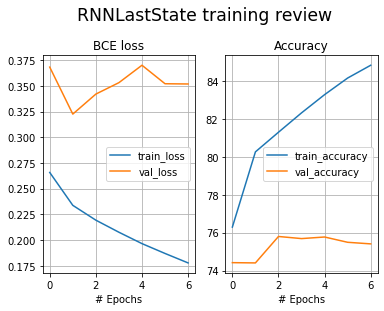

In [ ]:
# Since we split the training of the different kind of models between each member of the group, in order to merge the results in the notebook we plot the image resuming the training:

### 2. RNNAverage + 'concat'
Here we train the `RNNAverage` model with default 'concat' strategy.

In [ ]:
# clear gpu memory before another training:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Build model
encoder = RNNAverage(input_size=emb_dim, hidden_size=32, bidirectional = True, num_layers =1).to(DEVICE)  # 32 * 2 = 64 due to bidirectionality
classifier_in_features = encoder.get_output_dim() * 2 if merge_strategy == 'concat' else encoder.get_output_dim()
classifier = nn.Linear(in_features=classifier_in_features, out_features=1).to(DEVICE)
prover = ClaimProver(encoder, classifier).to(DEVICE)
save = "RNNAverage_training_review"

In [ ]:
# Define Adam optimizer
optimizer = torch.optim.Adam(prover.parameters(), lr=1e-3)

history = training_loop(model=prover,
                        train_data=train_data,
                        optimizer=optimizer,
                        epochs=EP,
                        batch_size=BS,
                        criterion=criterion,
                        train_embedder=train_embedder,
                        label_to_idx=label_to_idx,
                        val_embedder=val_embedder,
                        val_data=val_data,
                        early_stopping=True,
                        checkpoint_path='rnn_avg.pt')

plot_history(history, title='RNNAverage training review')

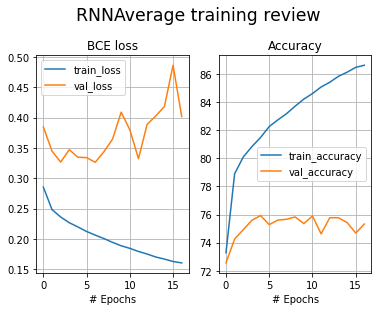

In [ ]:
# Since we split the training of the different kind of models between each member of the group, in order to merge the results in the notebook we plot the image resuming the training:

### 3. MLP + 'concat'
Here we train the `MLP` model with default 'concat' strategy.

Please notice that it needs the maximum length of sentences w.r.t. the whole dataset. This is actually a bad news for many reasons:

1) The test set could have longer sentences, in that case the MLP can't be applied unless:
  - the input sentence is truncated
  - the MLP is trained with some proper overhead in the maximum length of the training sentence.

2) Also if we are lucky and the test set doesn't contain longer sentences than the training set, the MLP has lots of useless parameters since it will likely often receive sentences with a lot of padding to reach the same length of the longest sentence.

In [ ]:
# clear gpu memory before another training:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Compute maximum length
max_len_train = max(map(len, train_corpus))

encoder = MLP([max_len_train * emb_dim, 64]).to(DEVICE)
classifier_in_features = encoder.get_output_dim() * 2 if merge_strategy == 'concat' else encoder.get_output_dim()
classifier = nn.Linear(in_features=classifier_in_features, out_features=1)
prover = ClaimProver(encoder, classifier).to(DEVICE)

In [ ]:
# Define Adam optimizer
optimizer = torch.optim.Adam(prover.parameters(), lr=1e-3)

history = training_loop(model=prover,
                        train_data=train_data,
                        optimizer=optimizer,
                        epochs=EP,
                        batch_size=BS,
                        criterion=criterion,
                        train_embedder=train_embedder,
                        label_to_idx=label_to_idx,
                        val_embedder=val_embedder,
                        val_data=val_data,
                        max_len=max_len_train,
                        early_stopping=True,
                        checkpoint_path='mlp.pt')

plot_history(history, title='MLP training review')

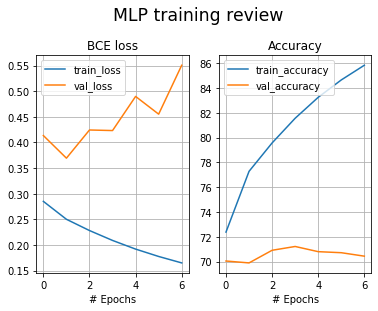

In [ ]:
# Since we split the training of the different kind of models between each member of the group, in order to merge the results in the notebook we plot the image resuming the training:

### 4. MeanEmbedder + 'concat'
Here we train the `MeanEmbedder` model with default 'concat' strategy.

In [ ]:
# clear gpu memory before another training:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Build model
encoder = MeanEmbedder(emb_dim).to(DEVICE)
classifier_in_features = encoder.get_output_dim() * 2 if merge_strategy == 'concat' else encoder.get_output_dim()
classifier = nn.Linear(in_features=classifier_in_features, out_features=1)
prover = ClaimProver(encoder, classifier).to(DEVICE)

In [ ]:
# Define Adam optimizer
optimizer = torch.optim.Adam(prover.parameters(), lr=1e-3)

history = training_loop(model=prover,
                        train_data=train_data,
                        optimizer=optimizer,
                        epochs=EP,
                        batch_size=BS,
                        criterion=criterion,
                        train_embedder=train_embedder,
                        label_to_idx=label_to_idx,
                        val_embedder=val_embedder,
                        val_data=val_data,
                        early_stopping=True,
                        checkpoint_path='mean.pt')

plot_history(history, title='MeanEmbedder training review')

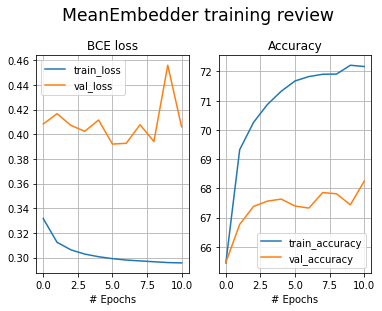

In [ ]:
# Since we split the training of the different kind of models between each member of the group, in order to merge the results in the notebook we plot the image resuming the training:

### The best model is RNNAverage

## Best model + other merging strategies
In this section, only the best model (`RNNAverage`) is trained with the alternative merging strategies:

- "avg";
- "sum".

The other training parameters remain the same as before.

### 1. Avg merging strategy

In [ ]:
# clear gpu memory before another training:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Build model
merge_strategy = 'avg'
encoder = RNNAverage(input_size=emb_dim, hidden_size=32, bidirectional = True).to(DEVICE)
classifier_in_features = encoder.get_output_dim() * 2 if merge_strategy == 'concat' else encoder.get_output_dim()
classifier = nn.Linear(in_features=classifier_in_features, out_features=1)# 32 * 2 = 64 due to bidirectionality
prover = ClaimProver(encoder, classifier, merge_strategy= merge_strategy).to(DEVICE)

In [ ]:
# Define Adam optimizer
optimizer = torch.optim.Adam(prover.parameters(), lr=1e-3)

history = training_loop(model=prover,
                        train_data=train_data,
                        optimizer=optimizer,
                        epochs=EP,
                        batch_size=BS,
                        criterion=criterion,
                        train_embedder=train_embedder,
                        label_to_idx=label_to_idx,
                        val_embedder=val_embedder,
                        val_data=val_data,
                        early_stopping=True,
                        checkpoint_path='rnn_avg_avgstr.pt')

plot_history(history, title='RNNAverage+Avg training review')

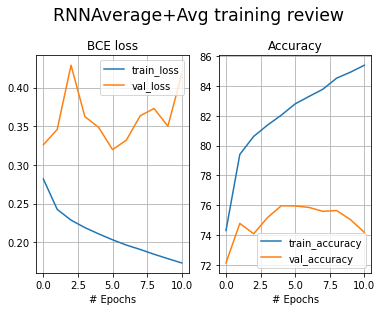

In [ ]:
# Since we split the training of the different kind of models between each member of the group, in order to merge the results in the notebook we plot the image resuming the training:

### 2. Sum merging strategy

In [ ]:
# clear gpu memory before another training:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Build model
merge_strategy = 'sum'
encoder = RNNAverage(input_size=emb_dim, hidden_size=32, bidirectional = True).to(DEVICE)
classifier_in_features = encoder.get_output_dim() * 2 if merge_strategy == 'concat' else encoder.get_output_dim()
classifier = nn.Linear(in_features=classifier_in_features, out_features=1)# 32 * 2 = 64 due to bidirectionality
prover = ClaimProver(encoder, classifier, merge_strategy).to(DEVICE)

In [ ]:
# Define Adam optimizer
optimizer = torch.optim.Adam(prover.parameters(), lr=1e-3)

history = training_loop(model=prover,
                        train_data=train_data,
                        optimizer=optimizer,
                        epochs=EP,
                        batch_size=BS,
                        criterion=criterion,
                        train_embedder=train_embedder,
                        label_to_idx=label_to_idx,
                        val_embedder=val_embedder,
                        val_data=val_data,
                        early_stopping=True,
                        checkpoint_path='rnn_avg_concatstr.pt')

plot_history(history, title='RNNAverage+Sum training review')

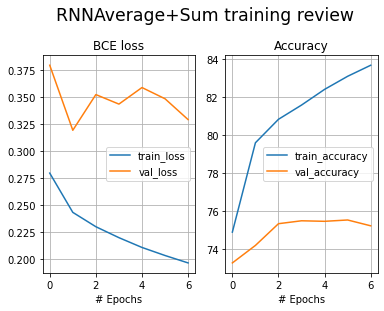

In [ ]:
# Since we split the training of the different kind of models between each member of the group, in order to merge the results in the notebook we plot the image resuming the training:

### The best merging strategy is 'concat'

## RNNAverage + 'concat' + cosine similarity 
In this section, the best model (`RNNAverage`) and the best merging strategy (`concat`) are used together with the cosine similarity extra feature.

In [ ]:
# clear gpu memory before another training:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Build model

use_cos_sim=True
merge_strategy='concat'

encoder = RNNAverage(input_size=emb_dim, hidden_size=32, bidirectional = True).to(DEVICE)  # 32 * 2 = 64 due to bidirectionality
classifier_in_features = encoder.get_output_dim() * 2 if merge_strategy == 'concat' else encoder.get_output_dim()
classifier = nn.Linear(in_features=classifier_in_features+use_cos_sim, out_features=1)
prover = ClaimProver(encoder, classifier, merge_strateg, use_cos_sim).to(DEVICE)

In [ ]:
# Define Adam optimizer
optimizer = torch.optim.Adam(prover.parameters(), lr=1e-3)

history = training_loop(model=prover,
                        train_data=train_data,
                        optimizer=optimizer,
                        epochs=EP,
                        batch_size=BS,
                        criterion=criterion,
                        train_embedder=train_embedder,
                        label_to_idx=label_to_idx,
                        val_embedder=val_embedder,
                        val_data=val_data,
                        early_stopping=True,
                        checkpoint_path='rnn_avg_concat_cossim.pt')

plot_history(history, title='RNNAverage+Concat+Cosine training review')

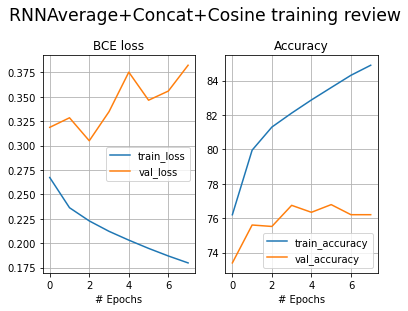

In [ ]:
# Since we split the training of the different kind of models between each member of the group, in order to merge the results in the notebook we plot the image resuming the training:

## RNNAverage + 'concat' + cosine similarity + 1 hidden layer classifier

In this section, the best model (`RNNAverage`) and the best merging strategy (`concat`) are used together with the cosine similarity extra feature, and the classifier with one hidden layer.

In [ ]:
# clear gpu memory before another training:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Build model
use_cos_sim = True
merge_strategy = 'concat'

encoder = RNNAverage(input_size=emb_dim, hidden_size=32, bidirectional=True, num_layers=1).to(DEVICE)  # 32 * 2 = 64 due to bidirectionality
classifier_in_features = encoder.get_output_dim() * 2 if merge_strategy == 'concat' else encoder.get_output_dim()
classifier = nn.Sequential(
                          nn.Linear(in_features=classifier_in_features + use_cos_sim, out_features=128),
                          nn.Linear(in_features=128, out_features=1)
                          ).to(DEVICE)
prover = ClaimProver(encoder, classifier, use_cos_sim=True).to(DEVICE)

In [ ]:
# Define Adam optimizer
optimizer = torch.optim.Adam(prover.parameters(), lr=1e-3)

history = training_loop(model=prover,
                        train_data=train_data,
                        optimizer=optimizer,
                        epochs=EP,
                        batch_size=BS,
                        criterion=criterion,
                        train_embedder=train_embedder,
                        label_to_idx=label_to_idx,
                        val_embedder=val_embedder,
                        val_data=val_data,
                        early_stopping=True,
                        checkpoint_path='rnn_avg_concat_cossim.pt')

plot_history(history, title='RNNAverage+Concat+Cosine+Classifier_hidden_layer training review')

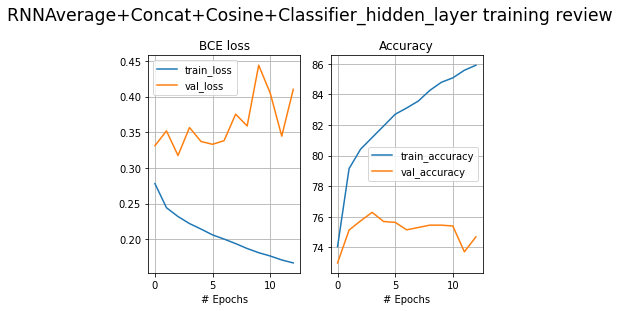

In [ ]:
#pil_img = Image("figure_RNNAverage+Concat+Cosine+Classifier_hidden_layer_training_review.png")
#display(pil_img)

As it can be seen, the best model is `RNNAverage` with `concat` strategy and cosine similarity feature. The hidden layer in the classifier actually decreases the performances.

# Performance evaluation

Due to our simplifications, obtained results are not directly compatible with a traditional fact checking method that considers the evidence set as a whole.

Thus, we need to consider two types of evaluations.

**Multi-input classification evaluation**

This type of evaluation is the easiest and concerns computing evaluation metrics, such as accuracy, f1-score, recall and precision, of our pre-processed dataset.

In other words, we assess the performance of chosen classifiers.

**Claim verification evaluation**

However, if we want to give an answer concerning the claim itself, we need to consider the whole evidence set. 

Intuitively, for a given claim, we consider all its corresponding (claim, evidence) pairs and their corresponding classification outputs. 

At this point, all we need to do is to compute the final predicted claim label via majority voting.

Example:

    Claim: c1
    Evidence set: e1, e2, e3
    True label: S

    Pair outputs:
    (c1, e1) -> S (supports)
    (c1, e2) -> S (supports)
    (c1, e3) -> R (refutes)

    Majority voting:
    S -> 2 votes
    R -> 1 vote

    Final label:
    c1 -> S

Lastly, we have to compute classification metrics just like before.

## performance evaluation functions definition:

In [ ]:
def compute_std_metrics(model: ClaimProver,
                        data: List[Tuple[List[str], List[str], str]],
                        batch_size: int,
                        embedder: Embedder,
                        label_to_idx: Dict[str, int],
                        max_len: Optional[int] = None):
    true_labels = []
    pred_labels = []

    with torch.no_grad():
      # Create batch iterator
      batch_iter = batch_iteration(data, batch_size)
      for batch in batch_iter:
          # Extract samples
          (claims, evidences, labels) = to_tuple_of_lists(batch)

          # Get encoding of claims, evidences and labels, and move them to GPU if available
          claims_tensor, claims_lengths = embedder.get_word_embedding(claims, max_len)
          evidences_tensor, evidences_lengths = embedder.get_word_embedding(evidences, max_len)
          claims_tensor = claims_tensor.to(DEVICE)
          evidences_tensor = evidences_tensor.to(DEVICE)
          labels_tensor = torch.FloatTensor([label_to_idx[l] for l in labels if len(l) > 0]).to(DEVICE)

          # Make prediction
          scores = model(claims_tensor, evidences_tensor, claims_lengths, evidences_lengths)
            
          # Compute output labels
          scores = torch.sigmoid(scores)
          predictions = scores.squeeze() > 0.5

          # Evaluate true and predicted labels
          for index, true_label in enumerate(labels_tensor):
            true_labels.append(int(true_label))
            if predictions[index]:
              pred_labels.append(1)
            else:
              pred_labels.append(0)
    
    print("Accuracy:  ", accuracy_score(true_labels, pred_labels))
    print("F1 score:  ", f1_score(true_labels, pred_labels))
    print("Recall:    ", recall_score(true_labels, pred_labels))
    print("Precision: ", precision_score(true_labels, pred_labels))

In [ ]:
def claims_true_labels(df_in: pd.DataFrame) -> Dict[str, bool]:

  acc = pd.DataFrame(columns=["Claim", "#Supports", "#Refutes"])
  for _, row in df_in.iterrows():
    if row["Claim"] in acc["Claim"].tolist():
      index = acc["Claim"].tolist().index(row["Claim"])
      acc = acc.reset_index(drop=True)
      if row["Label"] == "SUPPORTS":
        acc['#Supports'][index] = int(acc["#Supports"][index]) + 1
      else:
        acc['#Refutes'][index] = int(acc["#Refutes"][index]) + 1
    else:
      if row["Label"] == "SUPPORTS":
        tmp = pd.DataFrame([[row["Claim"], 1, 0]], columns=["Claim", "#Supports", "#Refutes"])
      else:
        tmp = pd.DataFrame([[row["Claim"], 0, 1]], columns=["Claim", "#Supports", "#Refutes"])
      acc = acc.append(tmp)

  claims_labels_dict = {}
  for _, row in acc.iterrows():
    if row["#Supports"] > row["#Refutes"]:
      claims_labels_dict[" ".join(nltk.word_tokenize(row["Claim"]))] = True
    else:
      claims_labels_dict[" ".join(nltk.word_tokenize(row["Claim"]))] = False

  return claims_labels_dict

In [ ]:
def claims_predicted_labels(model: ClaimProver,
                            data: List[Tuple[List[str], List[str], str]],
                            batch_size: int,
                            embedder: Embedder,
                            label_to_idx: Dict[str, int],
                            max_len: Optional[int] = None) -> Dict[str, bool]:

    claims_labels_dict = {}
    
    with torch.no_grad():
      # Create batch iterator
      batch_iter = batch_iteration(data, batch_size)
      for batch in batch_iter:
          # Extract samples
          (claims, evidences, labels) = to_tuple_of_lists(batch)

          # Get encoding of claims, evidences and labels, and move them to GPU if available
          claims_tensor, claims_lengths = embedder.get_word_embedding(claims, max_len)
          evidences_tensor, evidences_lengths = embedder.get_word_embedding(evidences, max_len)
          claims_tensor = claims_tensor.to(DEVICE)
          evidences_tensor = evidences_tensor.to(DEVICE)
          labels_tensor = torch.FloatTensor([label_to_idx[l] for l in labels if len(l) > 0]).to(DEVICE)

          # Make prediction
          scores = model(claims_tensor, evidences_tensor, claims_lengths, evidences_lengths)
            
          # Compute output labels
          scores = torch.sigmoid(scores)
          predictions = scores.squeeze() > 0.5

          # compute claim verification
          claims_flat = []
          for claim in claims:
            if claim:
              claims_flat.append(' '.join(claim))

          for index, claim in enumerate(claims_flat):
            if claim in claims_labels_dict:
              if predictions[index]:
                claims_labels_dict[claim] = (claims_labels_dict[claim][0],
                                             claims_labels_dict[claim][1] + 1)
              else:
                claims_labels_dict[claim] = (claims_labels_dict[claim][0] + 1,
                                             claims_labels_dict[claim][1])
            else:
              if predictions[index]:
                claims_labels_dict[claim] = (0, 1)
              else:
                claims_labels_dict[claim] = (1, 0)

      # compute voting
      for claim, votes in claims_labels_dict.items():
        if votes[0] > votes[1]:
          claims_labels_dict[claim] = False
        else:
          claims_labels_dict[claim] = True

    return claims_labels_dict

In [ ]:
def compute_metrics(ctl: Dict[str, bool], cpl: Dict[str, bool]):
  true_labels = []
  pred_labels = []
  for claim, label in ctl.items():
    true_labels.append(label)
    pred_labels.append(cpl[claim])

  print("Accuracy:  ", accuracy_score(true_labels, pred_labels))
  print("F1 score:  ", f1_score(true_labels, pred_labels))
  print("Recall:    ", recall_score(true_labels, pred_labels))
  print("Precision: ", precision_score(true_labels, pred_labels))

In [ ]:
###### Load the model: 

use_cos_sim=True
merge_strategy = 'concat'

encoder = RNNAverage(input_size=emb_dim, hidden_size=32, bidirectional = True).to(DEVICE)  # 32 * 2 = 64 due to bidirectionality
classifier_in_features = encoder.get_output_dim() * 2 if merge_strategy == 'concat' else encoder.get_output_dim()
classifier = nn.Linear(in_features=classifier_in_features+use_cos_sim, out_features=1)
prover = ClaimProver(encoder, classifier, merge_strategy='concat', use_cos_sim=use_cos_sim).to(DEVICE)

prover.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

In [ ]:
max_len_test = max(map(len, test_corpus))

compute_std_metrics(prover,
                    test_data,
                    BS,
                    test_embedder,
                    label_to_idx,
                    max_len_test)

Accuracy:   0.734594519404646
F1 score:   0.7239583333333333
Recall:     0.6938435940099834
Precision:  0.7568058076225045


In [ ]:
max_len_test = max(map(len, test_corpus))

ctl = claims_true_labels(df_test)
cpl = claims_predicted_labels(prover,
                              test_data,
                              BS, # BS
                              test_embedder,
                              label_to_idx,
                              max_len_test)
compute_metrics(ctl, cpl)

Accuracy:   0.7323727774371551
F1 score:   0.7213533354612194
Recall:     0.6904980140543844
Precision:  0.7550952221850986


# Error anaysis

In [ ]:
def order_by_error (data: List[Tuple[List[str], List[str]]], model: nn.Module, embedder: Embedder, max_len: int):
    # Extract samples
    (claims, evidences, labels) = to_tuple_of_lists(data)

    # Get encoding of claims, evidences and labels, and move them to GPU if available
    claims_tensor, claims_lengths = embedder.get_word_embedding(claims, max_len)
    evidences_tensor, evidences_lengths = embedder.get_word_embedding(evidences, max_len)
    claims_tensor = claims_tensor.to(DEVICE)
    evidences_tensor = evidences_tensor.to(DEVICE)
    labels_tensor = torch.FloatTensor([label_to_idx[l] for l in labels if len(l) > 0]).to(DEVICE)

    with torch.no_grad():
        # Make prediction
        scores = model(claims_tensor, evidences_tensor, claims_lengths, evidences_lengths)
        scores = torch.sigmoid(scores)
        scores.squeeze_(dim=1)

    # Compute absolute error between expected label and predicted score
    absolute_error =  torch.abs(labels_tensor - scores)

    predictions = (scores > 0.5).type(torch.int)

    return torch.argsort(absolute_error, descending=True), predictions

In [ ]:
indexes, predictions = order_by_error(test_data[:1000], prover, test_embedder, max_len_train)

(claims, evidences, labels) = to_tuple_of_lists(test_data[:1000])

for i in range(10):
    idx = indexes[i].item()

    print("Index:", idx)
    print("Claim:", " ".join(claims[idx]))
    print("Evidence:", " ".join(evidences[idx]))
    print("Predicted label:", idx_to_label[predictions[idx].item()])
    print("Correct label:", labels[idx])
    print("")

Index: 688
Claim: Barbarella is not non-fiction .
Evidence: Barbarella is a 1968 science fiction film directed by Roger Vadim based on the French comic Barbarella
Predicted label: REFUTES
Correct label: SUPPORTS

Index: 404
Claim: John Frusciante was incapable of releasing eleven solo albums .
Evidence: Frusciante has an active solo career having released eleven solo albums and five EPs his recordings include elements ranging from experimental rock and ambient music to new wave and electronica
Predicted label: REFUTES
Correct label: SUPPORTS

Index: 924
Claim: Hollow Man has zero sequels .
Evidence: A directtovideo standalone sequel called Hollow Man 2 starring Christian Slater and Peter Facinelli was released in 2006
Predicted label: REFUTES
Correct label: SUPPORTS

Index: 313
Claim: John Goodman starred in Cloverfield .
Evidence: His other film performances include lead roles in The Babe 1992 The Flintstones 1994 and 10 Cloverfield Lane 2016 and supporting roles in Coyote Ugly 2000 T

### There are different kind of errors:
    
* Confusion due to negation. To solve this problem it could be concatenated "not_" to all the words between the negation and the punctuation mark. Or it could be done some kind of flipping of the prediction depending on the number of negations, but this should be probably combined with a POS tagging to understand if the negation is referred to the same thing in the claim and in the evidence.

* Different order of the words could lead to very different sentence encodings of claim and evidence confuse the classification. Example: 

   - Claim: Hollow Man has zero sequels .
   - Evidence: ... standalone sequel called Hollow Man 2... 
   
   It could be solved with some clever way to order the words in the evidence according to some POS tagging and dependencies between words in the claim. 
   
* The Evidence is much longer than the claim, it could help an Attention technique.
   
* Some Evidence-Claim pairs are really difficult: the Claim uses completely different words to express the same concept which is in the Evidence, not using synonimous but for example "He starred in.." in the Evidence is expressed by "His film performances include...". Here the model is required to improve the semantic understanding.
   
* There are some bad samples in the dataset, some have a wrong label, some instead have no information in the Evidence about the Claim (this is due to the splitting done to simplify the problem).

In [ ]:
# Incorrect dataset label 

print("############################## INCORRECT LABELS OF THE DATASET: ##########################\n")

print("EXAMPLE1:\n")
index = 404 # which is also in contraddiction with the claim-evidence with index 403
print("Claim: \n", df_test['Claim'][index])
print("\nEvidence: \n", df_test['Evidence'][index])
print("\nLabel from the dataset: ",df_test['Label'][index])


print("\n\nEXAMPLE2:\n")
index =  273
print("Claim: \n", df_test['Claim'][index])
print("\nEvidence: \n", df_test['Evidence'][index])
print("\nLabel from the dataset: ",df_test['Label'][index])


# Not containing enough info samples:
print("\n\n############################## Evidence without informations about the Claim: ###########\n")
index =  394
print("Claim: \n", df_test['Claim'][index])
print("\nEvidence: \n", df_test['Evidence'][index])
print("\nLabel from the dataset: ",df_test['Label'][index])

############################## INCORRECT LABELS OF THE DATASET: ##########################

EXAMPLE1:

Claim: 
 John Frusciante was incapable of releasing eleven solo albums.

Evidence: 
 Frusciante has an active solo career  having released eleven solo albums and five EPs  his recordings include elements ranging from experimental rock and ambient music to new wave and electronica 

Label from the dataset:  SUPPORTS


EXAMPLE2:

Claim: 
 Aphrodite is a goddess in Greek mythology.

Evidence: 
 Aphrodite  Greek     is the Greek goddess of love  beauty  pleasure  and procreation 

Label from the dataset:  REFUTES


############################## Evidence without informations about the Claim: ###########

Claim: 
 There are 26 world title wins and 0 loss record under Floyd Mayweather Jr.

Evidence: 
 Champions recognized by sanctioning bodies such as the World Boxing Association  WBA  or World Boxing Council  WBC   or the Ultimate Fighting Championship  UFC  may vacate their title voluntar

# Report

The class "ClaimProver" retrieves a model which is a combination of an encoder and a classifier. The encoder can be: an MLP with any number of layers, an LSTM optionally bidirectional with any number of layers, a bag of vectors. The classifier is an MLP. We compared the baselines using the whole training set and validation set respectively to train and evaluate them. According to our experiments the best baseline model is the "RNNAverage", the best merging strategy is the concatenation and the cosine similarity improves the performance. Extras: oov dealing with weighted mean, weighted loss based on the label frequency, mixed precision to speed up the training, error analysis (some mistakes in the dataset have been found).